In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
import torch
import pickle
from functools import partial

from transformer_lens import HookedTransformer, HookedTransformerConfig
from huggingface_hub import hf_hub_download

from MIB_circuit_track.dataset import HFEAPDataset
from eap.graph import Graph
from eap.attribute import attribute
from eap.attribute_node import attribute_node
from MIB_circuit_track.metrics import get_metric
from MIB_circuit_track.utils import MODEL_NAME_TO_FULLNAME, TASKS_TO_HF_NAMES, COL_MAPPING

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Testing

In [3]:
model_name = "gpt2"
model = HookedTransformer.from_pretrained(model_name)
model.cfg.use_split_qkv_input = True
model.cfg.use_attn_result = True
model.cfg.use_hook_mlp_in = True
model.cfg.ungroup_grouped_query_attention = True

task = 'ioi'
graph = Graph.from_model(model, neuron_level=True, node_scores=False)

hf_task_name = f'mib-bench/{TASKS_TO_HF_NAMES[task]}'
dataset = HFEAPDataset(hf_task_name, model.tokenizer, split="validation", task=task, model_name=model_name, num_examples=1)

dataloader = dataset.to_dataloader(batch_size=1)
metric = get_metric('logit_diff', task, model.tokenizer, model)
attribution_metric = partial(metric, mean=True, loss=True)


Loaded pretrained model gpt2 into HookedTransformer


In [8]:
attribute_node(model, graph, dataloader, attribution_metric, "EAP", 
                    "patching", neuron=True, ig_steps=5,
                    optimal_ablation_path=None,
                    intervention_dataloader=dataloader)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


In [45]:
len(graph.nodes), graph.neurons_scores.shape, graph.neurons_in_graph.shape, graph.nodes_in_graph.shape

(158, torch.Size([157, 768]), torch.Size([157, 768]), torch.Size([157]))

In [27]:
from eap.evaluate import evaluate_graph, evaluate_baseline

baseline = evaluate_baseline(model, dataloader, attribution_metric).mean().item()
results = evaluate_graph(model, graph, dataloader, attribution_metric).mean().item()
print(f"Original performance was {baseline}; the circuit's performance is {results}")

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


Original performance was -3.20346736907959; the circuit's performance is 3.045830726623535


In [46]:
for node_name, node in graph.nodes.items():
    print(f"{node_name}: {graph.forward_index(node)}")

input: 0
a0.h0: slice(1, 13, None)
a0.h1: slice(1, 13, None)
a0.h2: slice(1, 13, None)
a0.h3: slice(1, 13, None)
a0.h4: slice(1, 13, None)
a0.h5: slice(1, 13, None)
a0.h6: slice(1, 13, None)
a0.h7: slice(1, 13, None)
a0.h8: slice(1, 13, None)
a0.h9: slice(1, 13, None)
a0.h10: slice(1, 13, None)
a0.h11: slice(1, 13, None)
m0: 13
a1.h0: slice(14, 26, None)
a1.h1: slice(14, 26, None)
a1.h2: slice(14, 26, None)
a1.h3: slice(14, 26, None)
a1.h4: slice(14, 26, None)
a1.h5: slice(14, 26, None)
a1.h6: slice(14, 26, None)
a1.h7: slice(14, 26, None)
a1.h8: slice(14, 26, None)
a1.h9: slice(14, 26, None)
a1.h10: slice(14, 26, None)
a1.h11: slice(14, 26, None)
m1: 26
a2.h0: slice(27, 39, None)
a2.h1: slice(27, 39, None)
a2.h2: slice(27, 39, None)
a2.h3: slice(27, 39, None)
a2.h4: slice(27, 39, None)
a2.h5: slice(27, 39, None)
a2.h6: slice(27, 39, None)
a2.h7: slice(27, 39, None)
a2.h8: slice(27, 39, None)
a2.h9: slice(27, 39, None)
a2.h10: slice(27, 39, None)
a2.h11: slice(27, 39, None)
m2: 39
a3.h

In [49]:
graph.to_json(f'circuits/debug/importances.json')

Node input in graph: False
Node a0.h0 in graph: False
Node a0.h1 in graph: False
Node a0.h2 in graph: False
Node a0.h3 in graph: False
Node a0.h4 in graph: False
Node a0.h5 in graph: False
Node a0.h6 in graph: False
Node a0.h7 in graph: False
Node a0.h8 in graph: False
Node a0.h9 in graph: False
Node a0.h10 in graph: False
Node a0.h11 in graph: False
Node m0 in graph: False
Node a1.h0 in graph: False
Node a1.h1 in graph: False
Node a1.h2 in graph: False
Node a1.h3 in graph: False
Node a1.h4 in graph: False
Node a1.h5 in graph: False
Node a1.h6 in graph: False
Node a1.h7 in graph: False
Node a1.h8 in graph: False
Node a1.h9 in graph: False
Node a1.h10 in graph: False
Node a1.h11 in graph: False
Node m1 in graph: False
Node a2.h0 in graph: False
Node a2.h1 in graph: False
Node a2.h2 in graph: False
Node a2.h3 in graph: False
Node a2.h4 in graph: False
Node a2.h5 in graph: False
Node a2.h6 in graph: False
Node a2.h7 in graph: False
Node a2.h8 in graph: False
Node a2.h9 in graph: False
Nod

In [51]:
graph = Graph.from_json('circuits/debug/importances.json')

In [52]:
from eap.evaluate import evaluate_graph, evaluate_baseline

baseline = evaluate_baseline(model, dataloader, attribution_metric).mean().item()
results = evaluate_graph(model, graph, dataloader, attribution_metric).mean().item()
print(f"Original performance was {baseline}; the circuit's performance is {results}")

100%|██████████| 1/1 [00:00<00:00, 12.37it/s]

Original performance was -3.20346736907959; the circuit's performance is 3.045830726623535


In [1]:
import pickle

with open('results/EAP_patching_neuron/ioi_gpt2_validation_abs-False.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
data

{'weighted_edge_counts': [3.28125,
  9.4140625,
  31.35416603088379,
  87.86458587646484,
  291.95703125,
  1420.6614990234375,
  5055.1484375,
  13690.2861328125,
  34932.48828125,
  69865.0],
 'area_under': 0.25095041562974435,
 'area_from_1': 0.7480495843702557,
 'average': 0.10142104345053557,
 'faithfulnesses': [0.0,
  0.0,
  0.0,
  -1.4140530751639912e-05,
  6.898501866689867e-05,
  0.0011000054684707906,
  0.0085503075944916,
  0.00769121043382629,
  -0.0031859334793482943,
  1.0]}

### testing custom

In [13]:
from custom_method import custom_attribute_node, get_scores_ig_activations_directional, asymmetry_score

In [17]:
corrupt_to_clean = get_scores_ig_activations_directional(
    model, graph, dataloader, metric, intervention='patching', 
    intervention_dataloader=dataloader, 
    optimal_ablation_path=None, quiet=False,
    neuron=True, patch_direction='patch-in-corrupt'
)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:09<00:00, 69.53s/it]


In [18]:
clean_to_corrupt = get_scores_ig_activations_directional(
        model, graph, dataloader, metric, intervention='patching', 
        intervention_dataloader=dataloader, 
        optimal_ablation_path=None, quiet=False,
        neuron=True, patch_direction='patch-in-clean')

100%|██████████| 1/1 [01:09<00:00, 69.81s/it]


In [21]:
corrupt_to_clean.shape, clean_to_corrupt.shape

(torch.Size([157, 768]), torch.Size([157, 768]))

In [29]:
scores_asymmetry = asymmetry_score(corrupt_to_clean, clean_to_corrupt)
abs_scores_asymmetry = scores_asymmetry.abs()
threshold = torch.quantile(abs_scores_asymmetry.flatten(), 0.9)

latent_components = abs_scores_asymmetry >= threshold
latent_components_indices = latent_components.nonzero()

In [31]:
scores = corrupt_to_clean.clone()

for n, d in latent_components_indices:
    scores[n, d] = clean_to_corrupt[n, d]

In [32]:
custom_attribute_node(model, graph, dataloader, attribution_metric, "patching", neuron=True, intervention_dataloader=dataloader)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [02:02<00:00, 122.25s/it]


In [33]:
from eap.evaluate import evaluate_graph, evaluate_baseline

baseline = evaluate_baseline(model, dataloader, attribution_metric).mean().item()
results = evaluate_graph(model, graph, dataloader, attribution_metric).mean().item()
print(f"Original performance was {baseline}; the circuit's performance is {results}")

100%|██████████| 1/1 [00:00<00:00,  9.80it/s]

Original performance was -3.20346736907959; the circuit's performance is 3.045830726623535


In [34]:
print(f"Faithfulness: {results / baseline}. Original {baseline}, new {results}")

Faithfulness: -0.9507918688426202. Original -3.20346736907959, new 3.045830726623535


In [ ]:
from MIB_circuit_track.evaluation import evaluate_area_under_curve

eval_auc_outputs = evaluate_area_under_curve(model, graph, dataloader, attribution_metric, level='neuron')
weighted_edge_counts, area_under, area_from_1, average, faithfulnesses = eval_auc_outputs

print(f"weighted_edge_counts: {weighted_edge_counts}")
print(f"area_under (cpr): {area_under}") # higher is better
print(f"area_from_1 (cmd): {area_from_1}") # lower is better
print(f"average: {average}")
print(f"faithfulnesses: {faithfulnesses}")

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


Computing results for 0.1% of neurons (N=120)


100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


Computing results for 0.2% of neurons (N=241)


100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computing results for 0.5% of neurons (N=602)


100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


Computing results for 1.0% of neurons (N=1205)


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Computing results for 2.0% of neurons (N=2411)


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


Computing results for 5.0% of neurons (N=6028)


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


Computing results for 10.0% of neurons (N=12057)


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Computing results for 20.0% of neurons (N=24115)


100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


Computing results for 50.0% of neurons (N=60288)


100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


Computing results for 100% of neurons (N=120576)


100%|██████████| 1/1 [00:00<00:00,  9.62it/s]

weighted_edge_counts: [1.25, 2.5104167461395264, 22.73177146911621, 95.70963287353516, 323.3502502441406, 1373.5677490234375, 4160.29296875, 12088.8994140625, 34932.50390625, 69865.0]
area_under (cpr): 0.8379132548760359
area_from_1 (cmd): 0.17193037014044543
average: 0.32901708321735346
faithfulnesses: [-1.5260502888507987e-07, 1.5260502888507987e-07, -0.0019821867201883026, 0.003414537521303662, 0.016788689647763175, 0.1326497848879513, 0.38653678757868315, 0.7392086879874205, 1.0135545312706016, 1.0]


### Evaluations

In [9]:
import pickle
import matplotlib.pyplot as plt

In [10]:
def plot_faithfulness(data_path: str, method_name: str):
    with open(path, 'rb') as f:
        data = pickle.load(f)
        
    k = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
    faithfulness_scores = data['faithfulnesses']

    plt.figure(figsize=(10, 6))
    plt.plot(k, faithfulness_scores, marker='o')

    plt.xlabel("Fraction of components in circuit")
    plt.ylabel("Faithfulness")
    plt.title(f"Faithfulness against circuit size for {method_name}")

    plt.hlines(y=1, xmin=0, xmax=1, linestyles='dotted')
    plt.fill_between(k, faithfulness_scores, 1, interpolate=True, color='lightskyblue', alpha=0.5, label='CMD')
    plt.fill_between(k, faithfulness_scores, 0, interpolate=True, color='lightpink', alpha=0.5, label='CPR')
    plt.xscale('log')

    plt.legend(loc=(1.04, 0.8))
    plt.show()

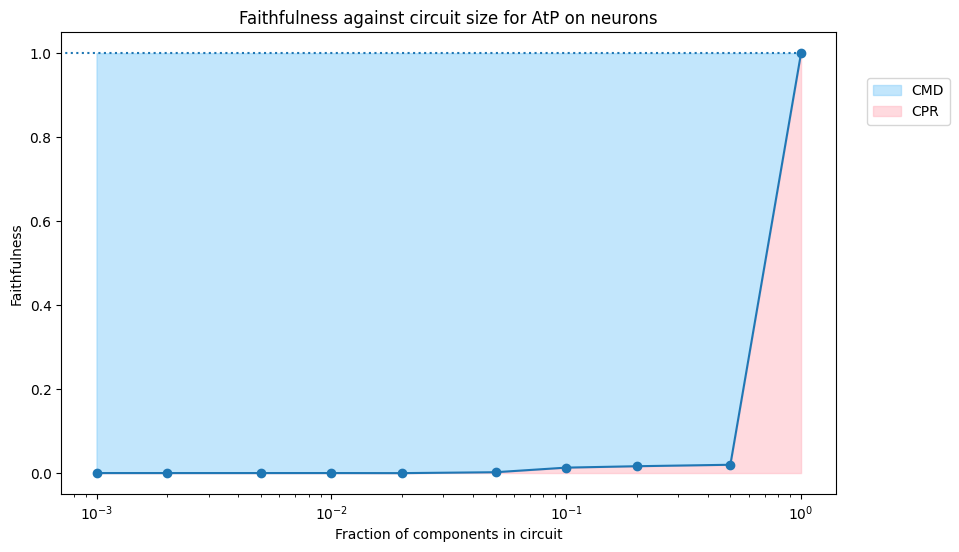

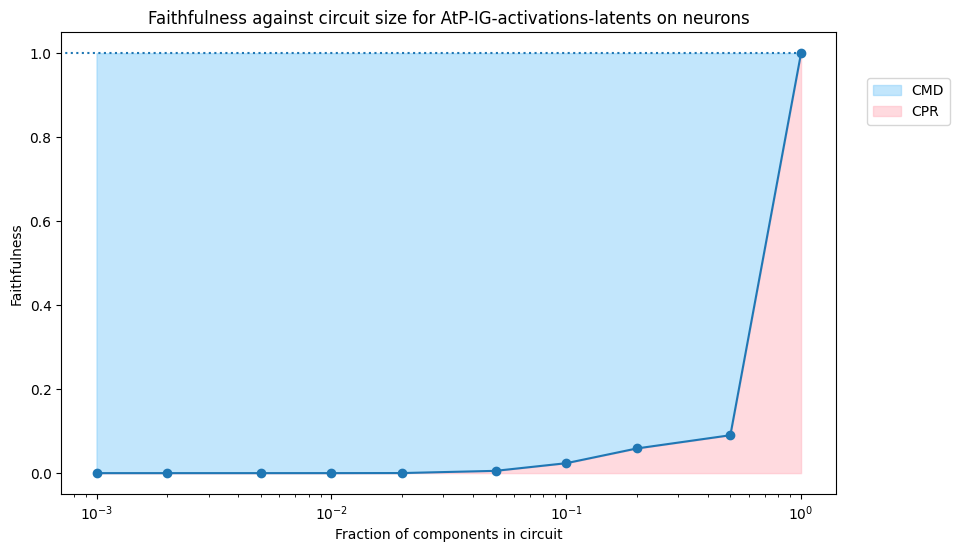

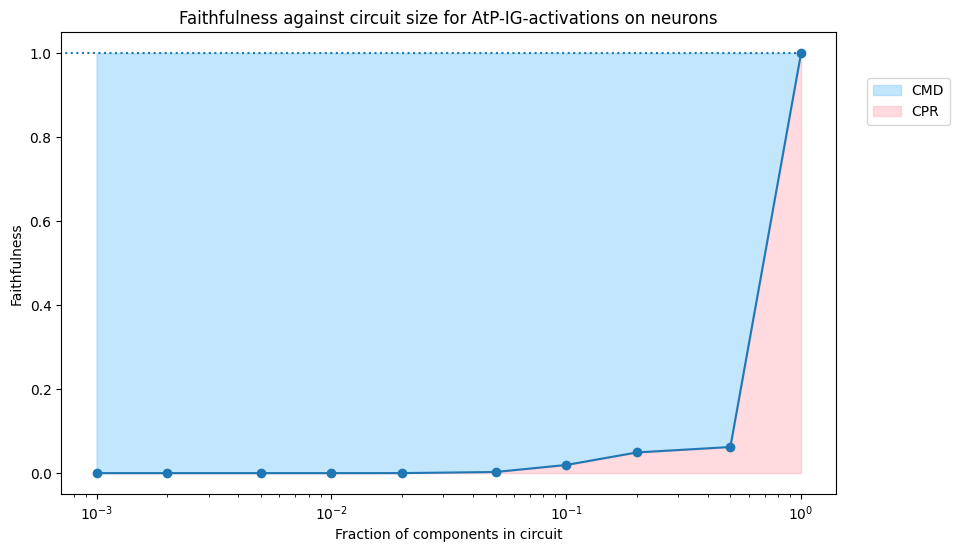

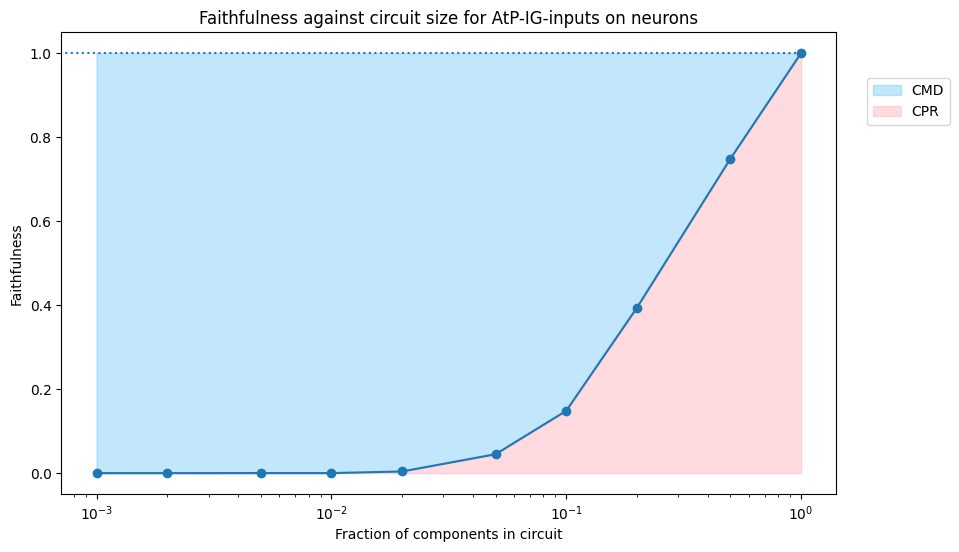

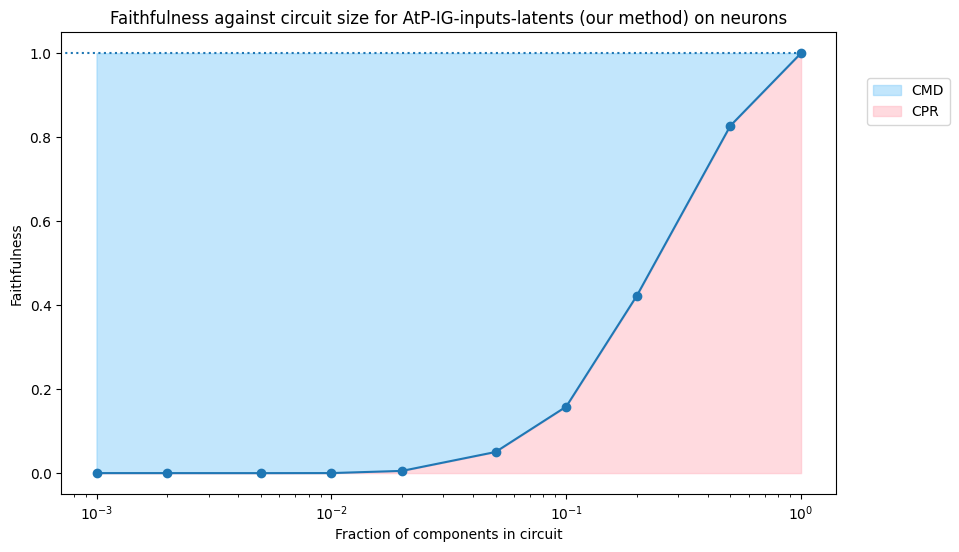

In [20]:
path = 'results/EAP_patching_neuron/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP on neurons")

# Activations

path = 'results/custom_patching_neuron/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP-IG-activations-latents on neurons")

path = 'results/EAP-IG-activations_patching_neuron/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP-IG-activations on neurons")

# Inputs

path = 'results/EAP-IG-inputs_patching_neuron/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP-IG-inputs on neurons")

path = 'results/custom-inputs_patching_neuron/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP-IG-inputs-latents (our method) on neurons")

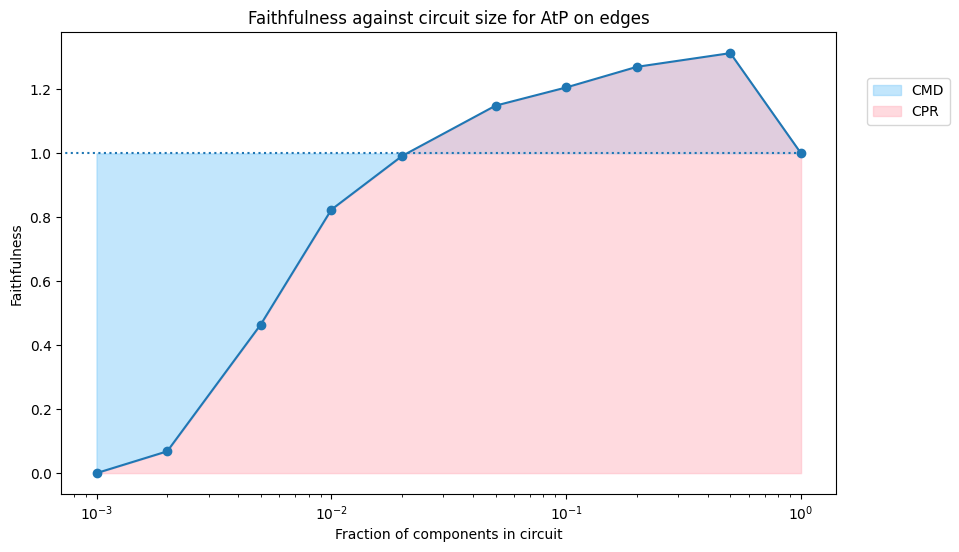

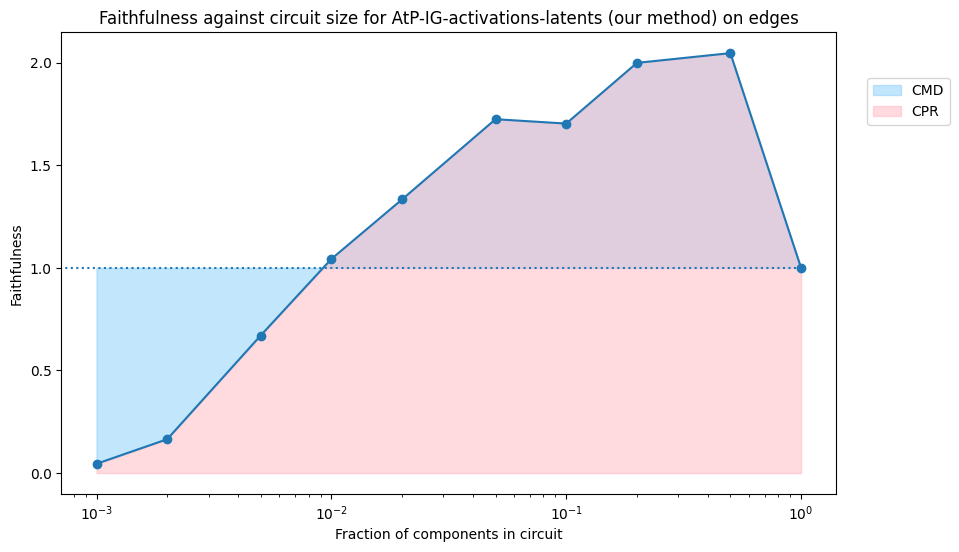

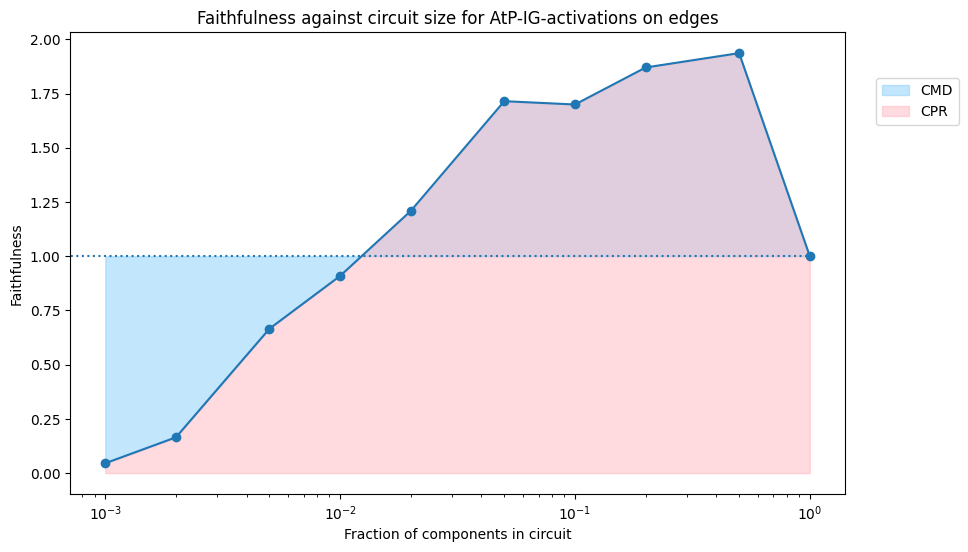

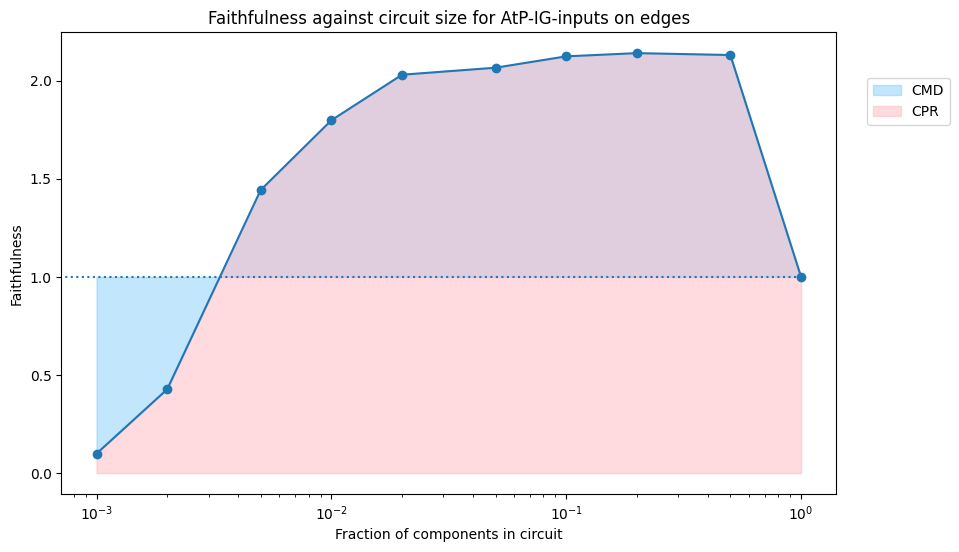

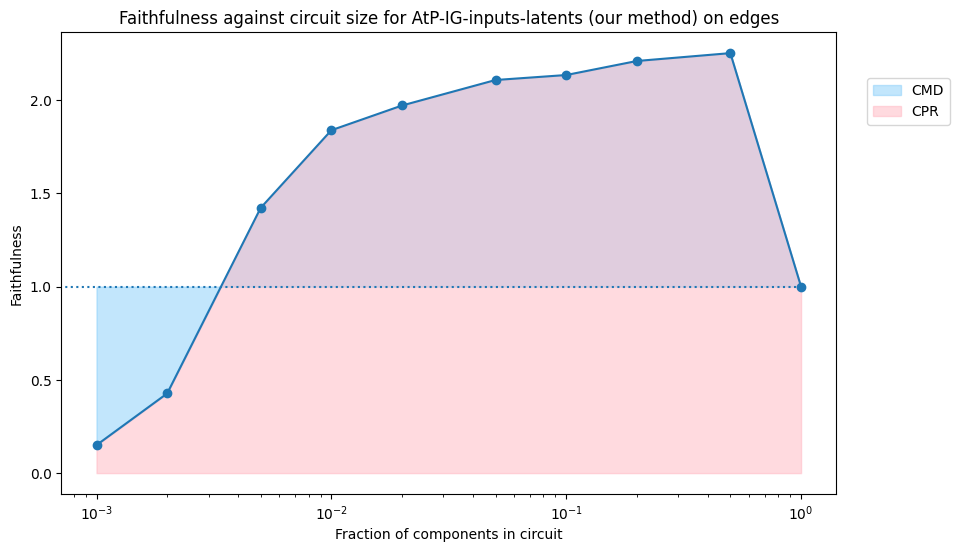

In [21]:
path = 'results/EAP_patching_edge/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP on edges")

# Activations

path = 'results/custom_patching_edge/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP-IG-activations-latents (our method) on edges")

path = 'results/EAP-IG-activations_patching_edge/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP-IG-activations on edges")

# Inputs

path = 'results/EAP-IG-inputs_patching_edge/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP-IG-inputs on edges")

path = 'results/custom-inputs_patching_edge/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP-IG-inputs-latents (our method) on edges")

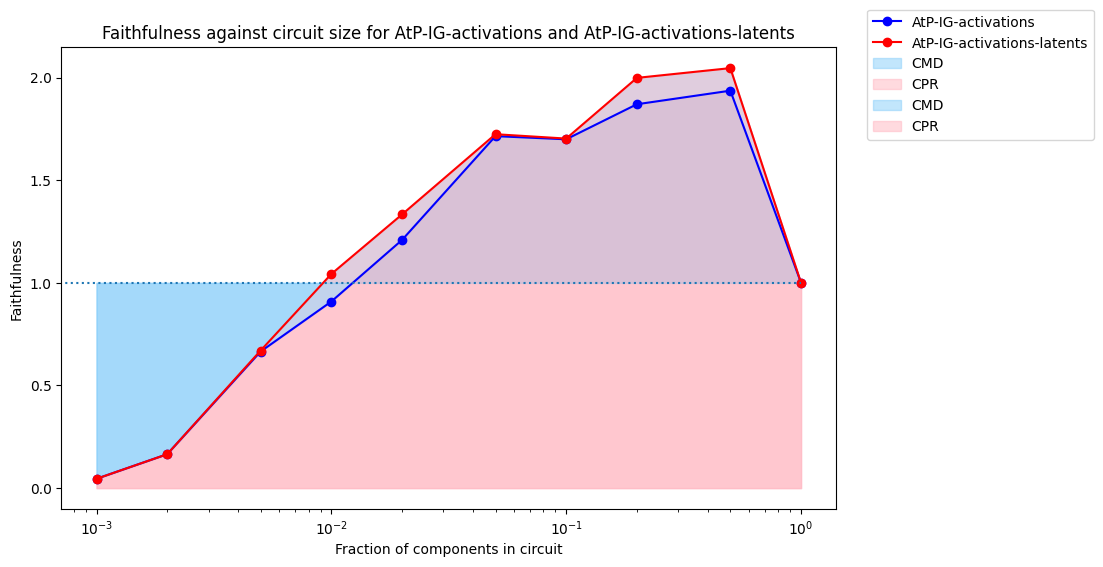

In [19]:
# Plot faithfulness curves of AtP-IG-activations and AtP-IG-activations-latents on the same plot for edges
atp_ig_activations_path = 'results/EAP-IG-activations_patching_edge/ioi_gpt2_test_abs-False.pkl'
atp_ig_activations_latents_path = 'results/custom_patching_edge/ioi_gpt2_test_abs-False.pkl'

plt.figure(figsize=(10, 6))

k = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

with open(atp_ig_activations_path, 'rb') as f:
    atp_ig_activations_data = pickle.load(f)

atp_ig_activations_faithfulness_scores = atp_ig_activations_data['faithfulnesses']
plt.plot(k, atp_ig_activations_faithfulness_scores, marker='o', color='blue', label='AtP-IG-activations')

with open(atp_ig_activations_latents_path, 'rb') as f:
    atp_ig_activations_latents_data = pickle.load(f)

atp_ig_activations_latents_faithfulness_scores = atp_ig_activations_latents_data['faithfulnesses']
plt.plot(k, atp_ig_activations_latents_faithfulness_scores, marker='o', color='red', label='AtP-IG-activations-latents')

plt.xlabel("Fraction of components in circuit")
plt.ylabel("Faithfulness")
plt.title(f"Faithfulness against circuit size for AtP-IG-activations and AtP-IG-activations-latents")

plt.hlines(y=1, xmin=0, xmax=1, linestyles='dotted')
plt.fill_between(k, atp_ig_activations_latents_faithfulness_scores, 1, interpolate=True, color='lightskyblue', alpha=0.5, label='CMD')
plt.fill_between(k, atp_ig_activations_latents_faithfulness_scores, 0, interpolate=True, color='lightpink', alpha=0.5, label='CPR')
plt.fill_between(k, atp_ig_activations_faithfulness_scores, 1, interpolate=True, color='lightskyblue', alpha=0.5, label='CMD')
plt.fill_between(k, atp_ig_activations_faithfulness_scores, 0, interpolate=True, color='lightpink', alpha=0.5, label='CPR')
plt.xscale('log')

plt.legend(loc=(1.04, 0.8))
plt.show()

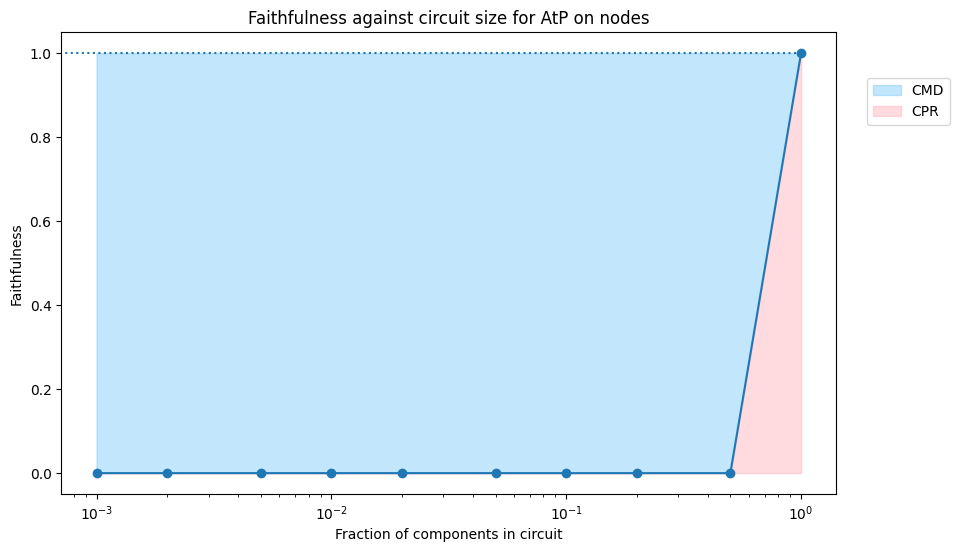

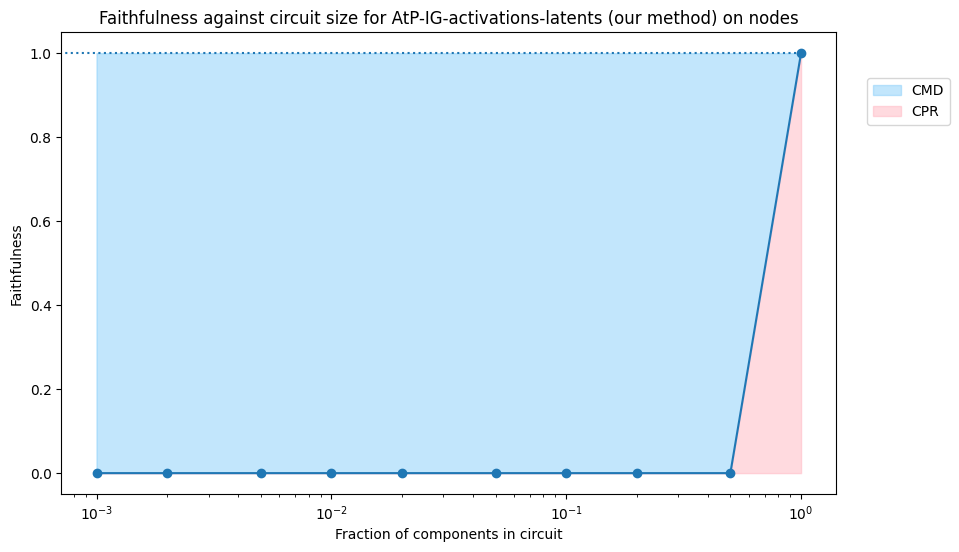

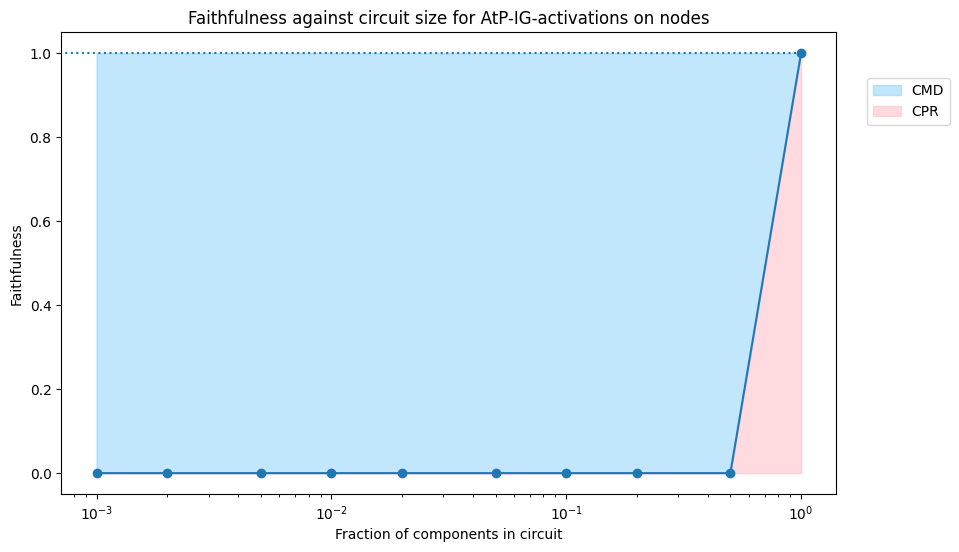

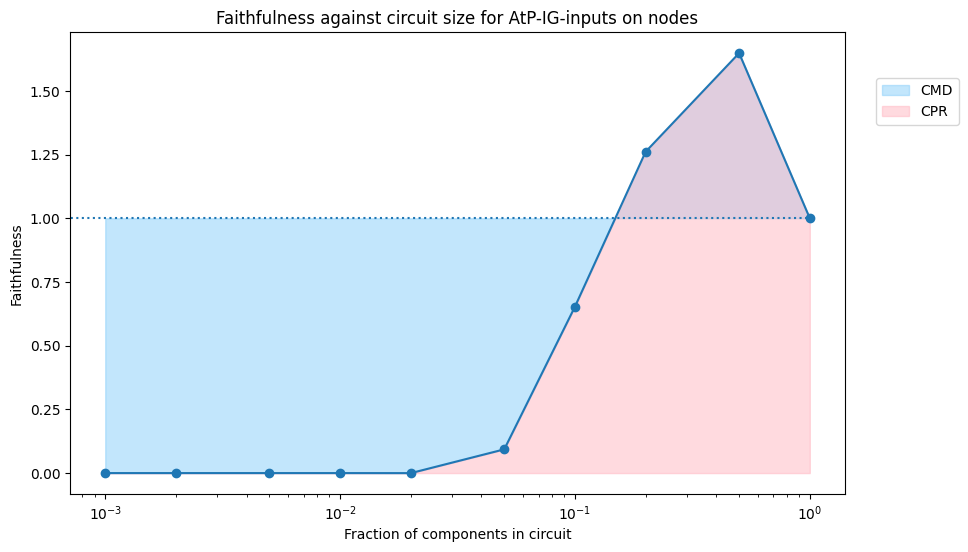

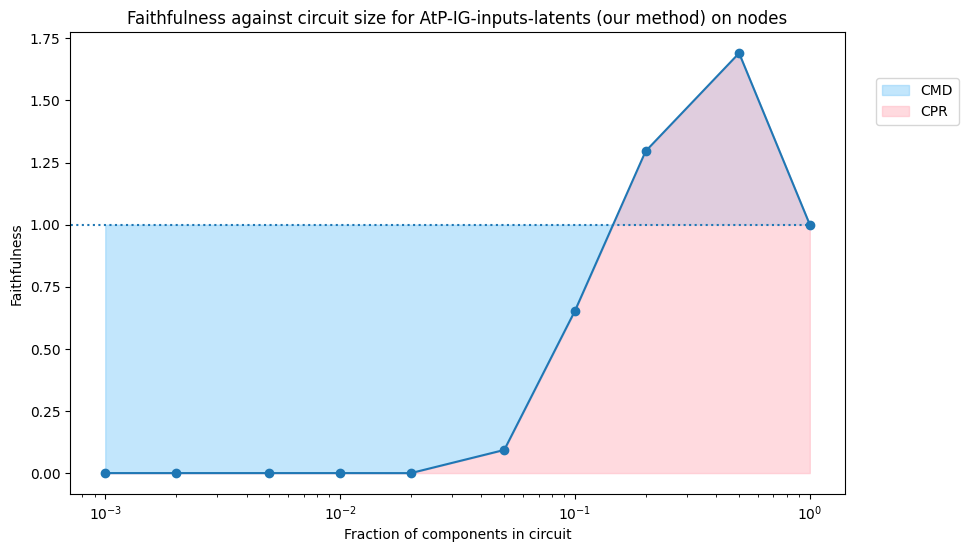

In [11]:
path = 'results/EAP_patching_node/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP on nodes")

# Activations

path = 'results/custom_patching_node/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP-IG-activations-latents (our method) on nodes")

path = 'results/EAP-IG-activations_patching_node/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP-IG-activations on nodes")

# Inputs
path = 'results/EAP-IG-inputs_patching_node/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP-IG-inputs on nodes")

path = 'results/custom-inputs_patching_node/ioi_gpt2_test_abs-False.pkl'
plot_faithfulness(path, "AtP-IG-inputs-latents (our method) on nodes")

In [ ]:
# Plot faithfulness curves of AtP-IG-inputs and AtP-IG-inputs-latents on the same plot
atp_ig_inputs_path = 'results/EAP-IG-inputs_patching_node/ioi_gpt2_test_abs-False.pkl'
atp_ig_inputs_latents_path = 'results/custom-inputs_patching_node/ioi_gpt2_test_abs-False.pkl'

plt.figure(figsize=(10, 6))

k = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

with open(atp_ig_inputs_path, 'rb') as f:
    atp_ig_inputs_data = pickle.load(f)

atp_ig_inputs_faithfulness_scores = atp_ig_inputs_data['faithfulnesses']
plt.plot(k, atp_ig_inputs_faithfulness_scores, marker='o', color='blue', label='AtP-IG-inputs')

with open(atp_ig_inputs_latents_path, 'rb') as f:
    atp_ig_inputs_latents_data = pickle.load(f)

atp_ig_inputs_latents_faithfulness_scores = atp_ig_inputs_latents_data['faithfulnesses']
plt.plot(k, atp_ig_inputs_latents_faithfulness_scores, marker='o', color='red', label='AtP-IG-inputs-latents')

plt.xlabel("Fraction of components in circuit")
plt.ylabel("Faithfulness")
plt.title(f"Faithfulness against circuit size for AtP-IG-inputs and AtP-IG-inputs-latents")

plt.hlines(y=1, xmin=0, xmax=1, linestyles='dotted')
plt.fill_between(k, atp_ig_inputs_faithfulness_scores, 1, interpolate=True, color='lightskyblue', alpha=0.5, label='CMD')
plt.fill_between(k, atp_ig_inputs_faithfulness_scores, 0, interpolate=True, color='lightpink', alpha=0.5, label='CPR')
plt.fill_between(k, atp_ig_inputs_latents_faithfulness_scores, 1, interpolate=True, color='lightskyblue', alpha=0.5, label='CMD')
plt.fill_between(k, atp_ig_inputs_latents_faithfulness_scores, 0, interpolate=True, color='lightpink', alpha=0.5, label='CPR')
plt.xscale('log')

plt.legend(loc=(1.04, 0.8))
plt.show()

### Significance testing

In [4]:
import math
import pickle

def calculate_std(data_path: str, method_name: str):
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
        
    stds = data['faithfulnesses_std']
    avg_std = math.sqrt(sum(d ** 2 for d in stds) / len(stds))
    print(f"Standard deviation of CPR and CMD scores for {method_name}: {avg_std}")
    return avg_std

In [ ]:
atp_neurons_path = 'results/EAP_patching_neuron/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_neurons_path, "AtP on neurons")

atp_latents_neurons_path = 'results/custom-eap_patching_neuron/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_latents_neurons_path, "AtP-latents on neurons")

# Activations

atp_ig_activations_latents_neurons_path = 'results/custom_patching_neuron/ioi_gpt2_test_abs-False.pkl'
calculate_std(path, "AtP-IG-activations-latents on neurons")

atp_ig_activations_neurons_path = 'results/EAP-IG-activations_patching_neuron/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_ig_activations_neurons_path, "AtP-IG-activations on neurons")

# Inputs

atp_ig_inputs_neurons_path = 'results/EAP-IG-inputs_patching_neuron/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_ig_inputs_neurons_path, "AtP-IG-inputs on neurons")

atp_ig_inputs_latents_neurons_path = 'results/custom-inputs_patching_neuron/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_ig_inputs_latents_neurons_path, "AtP-IG-inputs-latents (our method) on neurons")

Standard deviation of CPR and CMD scores for AtP on neurons: 0.21956018820922257
Standard deviation of CPR and CMD scores for AtP-latents on neurons: 0.21914840900753346
Standard deviation of CPR and CMD scores for AtP-IG-activations-latents on neurons: 0.2569734770270846
Standard deviation of CPR and CMD scores for AtP-IG-activations on neurons: 0.22005433055280413
Standard deviation of CPR and CMD scores for AtP-IG-inputs on neurons: 0.2569734770270846
Standard deviation of CPR and CMD scores for AtP-IG-inputs-latents (our method) on neurons: 0.25653769282239597


0.25653769282239597

In [6]:
from scipy.stats import ttest_ind_from_stats

# Calculate statistical significance of the difference in CPR and CMD between two methods
def ttest_cpr_cmd(data_path1: str, data_path2: str, method_name1: str, method_name2: str):

    print(f"T-test between {method_name1} and {method_name2}:")

    with open(data_path1, 'rb') as f:
        data1 = pickle.load(f)
        
    with open(data_path2, 'rb') as f:
        data2 = pickle.load(f)
    
    cpr1 = data1['area_under']
    cpr2 = data2['area_under']

    cmd1 = data1['area_from_1']
    cmd2 = data2['area_from_1']
    
    data1_std = calculate_std(data_path1, method_name1)
    data2_std = calculate_std(data_path2, method_name2)

    t_stat, p_value = ttest_ind_from_stats(cpr1, data1_std, 10_000, cpr2, data2_std, 10_000, equal_var=True)
    print(f"(CPR) T-statistic: {t_stat}, P-value: {p_value}")
    
    t_stat, p_value = ttest_ind_from_stats(cmd1, data1_std, 10_000, cmd2, data2_std, 10_000, equal_var=True)
    print(f"(CMD) T-statistic: {t_stat}, P-value: {p_value}")


In [37]:
# ttest_cpr_cmd(atp_neurons_path, atp_latents_neurons_path, "AtP on neurons", "AtP-latents on neurons")

ttest_cpr_cmd(atp_ig_activations_neurons_path, atp_ig_activations_latents_neurons_path,
              "AtP-IG-activations on neurons", "AtP-IG-activations-latents on neurons")

ttest_cpr_cmd(atp_ig_inputs_neurons_path, atp_ig_inputs_latents_neurons_path,
              "AtP-IG-inputs on neurons", "AtP-IG-inputs-latents on neurons")

T-test between AtP-IG-activations on neurons and AtP-IG-activations-latents on neurons:
Standard deviation of CPR and CMD scores for AtP-IG-activations on neurons: 0.22005433055280413
Standard deviation of CPR and CMD scores for AtP-IG-activations-latents on neurons: 0.22015457915255074
(CPR) T-statistic: -4.355673761711538, P-value: 1.3331814011152957e-05
(CMD) T-statistic: 4.35567376171152, P-value: 1.3331814011154025e-05
T-test between AtP-IG-inputs on neurons and AtP-IG-inputs-latents on neurons:
Standard deviation of CPR and CMD scores for AtP-IG-inputs on neurons: 0.2569734770270846
Standard deviation of CPR and CMD scores for AtP-IG-inputs-latents on neurons: 0.25653769282239597
(CPR) T-statistic: -10.510096577497613, P-value: 9.06014406421225e-26
(CMD) T-statistic: 10.510096577497583, P-value: 9.060144064214979e-26


In [9]:
atp_edges_path = 'results/EAP_patching_edge/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_edges_path, "AtP on edges")

atp_latents_edges_path = 'results/custom-eap_patching_edge/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_latents_edges_path, "AtP-latents on edges")

# Activations
atp_ig_activations_latents_edges_path = 'results/custom_patching_edge/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_ig_activations_latents_edges_path, "AtP-IG-activations-latents on edges")

atp_ig_activations_edges_path = 'results/EAP-IG-activations_patching_edge/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_ig_activations_edges_path, "AtP-IG-activations on edges")

# Inputs
atp_ig_inputs_edges_path = 'results/EAP-IG-inputs_patching_edge/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_ig_inputs_edges_path, "AtP-IG-inputs on edges")

atp_ig_inputs_latents_edges_path = 'results/custom-inputs_patching_edge/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_ig_inputs_latents_edges_path, "AtP-IG-inputs-latents (our method) on edges")

Standard deviation of CPR and CMD scores for AtP on edges: 0.4219966714653108
Standard deviation of CPR and CMD scores for AtP-latents on edges: 0.4219966714653108
Standard deviation of CPR and CMD scores for AtP-IG-activations-latents on edges: 0.47936305558421793
Standard deviation of CPR and CMD scores for AtP-IG-activations on edges: 0.47473677577194956
Standard deviation of CPR and CMD scores for AtP-IG-inputs on edges: 0.4090321714730736
Standard deviation of CPR and CMD scores for AtP-IG-inputs-latents (our method) on edges: 0.4246439716151288


0.4246439716151288

In [10]:
ttest_cpr_cmd(atp_ig_activations_edges_path, atp_ig_activations_latents_edges_path,
              "AtP-IG-activations on edges", "AtP-IG-activations-latents on edges")

ttest_cpr_cmd(atp_ig_inputs_edges_path, atp_ig_inputs_latents_edges_path,
              "AtP-IG-inputs on edges", "AtP-IG-inputs-latents on edges")

T-test between AtP-IG-activations on edges and AtP-IG-activations-latents on edges:
Standard deviation of CPR and CMD scores for AtP-IG-activations on edges: 0.47473677577194956
Standard deviation of CPR and CMD scores for AtP-IG-activations-latents on edges: 0.47936305558421793
(CPR) T-statistic: -10.93835157884224, P-value: 9.057387727863887e-28
(CMD) T-statistic: -10.730796410031175, P-value: 8.631128774762055e-27
T-test between AtP-IG-inputs on edges and AtP-IG-inputs-latents on edges:
Standard deviation of CPR and CMD scores for AtP-IG-inputs on edges: 0.4090321714730736
Standard deviation of CPR and CMD scores for AtP-IG-inputs-latents on edges: 0.4246439716151288
(CPR) T-statistic: -10.868297776735487, P-value: 1.9475737165839606e-27
(CMD) T-statistic: -10.859660963209993, P-value: 2.139648120040547e-27


In [7]:
atp_nodes_path = 'results/EAP_patching_node/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_nodes_path, "AtP on nodes")

atp_latents_nodes_path = 'results/custom-eap_patching_node/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_latents_nodes_path, "AtP-latents on nodes")

# Activations
atp_ig_activations_latents_nodes_path = 'results/custom_patching_node/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_ig_activations_latents_nodes_path, "AtP-IG-activations-latents on nodes")

atp_ig_activations_nodes_path = 'results/EAP-IG-activations_patching_node/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_ig_activations_nodes_path, "AtP-IG-activations on nodes")

# Inputs
atp_ig_inputs_nodes_path = 'results/EAP-IG-inputs_patching_node/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_ig_inputs_nodes_path, "AtP-IG-inputs on nodes")

atp_ig_inputs_latents_nodes_path = 'results/custom-inputs_patching_node/ioi_gpt2_test_abs-False.pkl'
calculate_std(atp_ig_inputs_latents_nodes_path, "AtP-IG-inputs-latents (our method) on nodes")

ttest_cpr_cmd(atp_ig_activations_nodes_path, atp_ig_activations_latents_nodes_path,
              "AtP-IG-activations on nodes", "AtP-IG-activations-latents on nodes")
              
ttest_cpr_cmd(atp_ig_inputs_nodes_path, atp_ig_inputs_latents_nodes_path,
              "AtP-IG-inputs on nodes", "AtP-IG-inputs-latents on nodes")

Standard deviation of CPR and CMD scores for AtP on nodes: 0.2199849024884145
Standard deviation of CPR and CMD scores for AtP-latents on nodes: 0.21998490416707062
Standard deviation of CPR and CMD scores for AtP-IG-activations-latents on nodes: 0.21998490416707062
Standard deviation of CPR and CMD scores for AtP-IG-activations on nodes: 0.21998490416707062
Standard deviation of CPR and CMD scores for AtP-IG-inputs on nodes: 0.27069361736442027
Standard deviation of CPR and CMD scores for AtP-IG-inputs-latents (our method) on nodes: 0.27302787564191855
T-test between AtP-IG-activations on nodes and AtP-IG-activations-latents on nodes:
Standard deviation of CPR and CMD scores for AtP-IG-activations on nodes: 0.21998490416707062
Standard deviation of CPR and CMD scores for AtP-IG-activations-latents on nodes: 0.21998490416707062
(CPR) T-statistic: 3.5317779605210132e-06, P-value: 0.9999971820841208
(CMD) T-statistic: -3.5317779783641972e-06, P-value: 0.9999971820841066
T-test between At